In [1]:
import common.star_api.design_manager as dm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.typing as npt
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

version = dm.STARCCMInstall(r"E:\Siemens\STARCCM\starpy\STAR-CCM+19.04.007-2-ga404231\star\bin\starccm+.bat")
work_dir = Path(r"E:\OneDrive - Siemens AG\mdx\hackathon\2024\starPy\exhaust")
name = "exhaust_test"

In [2]:
dmprj = dm.DesignManagerProject.get_proj(work_dir=work_dir, dmprj=name, version=version)
study = dmprj.studies[0]
all_best = study.get_design_set("All Best").data_frame()
all_best.style

,Design#,Name,Uniformity - Velocity MA,Pressure Drop MA (Pa),Iteration,Pressure Drop (Pa),Uniformity - Velocity,Performance,Bottom_Angle_Param (deg),ExtAngle (deg),HorizontalExt (ft),MoveVane_X (ft),MoveVane_Y (ft),Thickness (in),Top_Angle_Param (deg),Turning_Vane_Radius (ft),VerticalExt (ft)
0,1,"""Design 1""",0.810511,119.471727,672,119.473055,0.810601,-3270.798915,0,90,5.000000,0.000000,0.000000,1.000000,0,0.250000,5.000000
2,3,"""Design 3""",0.813053,72.405679,897,72.351269,0.812992,1.003136,18,73,11.000000,-1.750000,3.000000,2.000000,9,1.375000,3.750000
4,5,"""Design 5""",0.842762,69.687904,922,69.682751,0.842791,1.039791,14,100,0.250000,0.000000,2.250000,1.250000,11,2.375000,16.500000
15,16,"""Design 16""",0.895131,71.704070,852,71.653214,0.895062,1.104403,13,99,0.750000,4.250000,-1.500000,1.250000,11,3.375000,15.250000
42,43,"""Design 43""",0.905338,75.184547,707,75.196243,0.905115,1.116996,13,99,0.750000,3.750000,-1.000000,1.250000,11,1.375000,14.250000


In [3]:
def get_required_columns(src_study, response = None):
    param_names = [p.name for p in src_study.parameters]
    data = src_study.get_all_designs().data_frame()
    columns = []
    for p in param_names:
        for c in data.columns:
            regex = f"^{p}( \(.*\))?$"
            if re.match(regex, c):
                columns.append(c)
    if response is not None:
        for c in data.columns:
            if response in c:
                columns.append(c)
    return columns

In [4]:
def get_compatible_studies(studies, columns):
    comp_studies = []
    for study_i in studies:
        data = study_i.get_all_designs().data_frame()
        all_found = True
        for col in columns:
            if col not in data.columns:
                all_found = False
        if all_found:
            comp_studies.append(study_i)
    return comp_studies

In [5]:
def import_data(proj, src_study, response, study_regex = None):
    if study_regex is None:
        studies = proj.studies
    else:
        studies = [s for s in proj.studies if re.match(study_regex, s.name)]
    cols = get_required_columns(src_study=src_study, response=response)
    studies = get_compatible_studies(studies=studies, columns=cols)
    print(f"Found {len(studies)} compatible studies in design manager project.")
    df = src_study.get_all_designs().data_frame()
    for s in studies:
        df = pd.concat([df, s.get_all_designs().data_frame()], ignore_index=True, sort=False)
    df = df[cols]
    print(f"Extracted {len(df):,} designs for model training.")
    return df

In [6]:
def build_and_compile_model(norm):
    m = keras.Sequential([norm,
                          # layers.Dense(64, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(1)
                          ])
    m.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return m

In [7]:
def plot_loss(hist):
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], label='Training Loss')
    ax.plot(hist.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error [Pressure Drop (Pa)]')
    ax.legend()
    plt.show()

In [8]:
def plot_model_results(labels, predictions):
    f, a = plt.subplots(figsize=(8.0, 8.0))
    a.scatter(labels, predictions)
    a.set_xlabel("Simulated Pressure Drop (Pa)")
    a.set_ylabel("NN Predicted Pressure Drop (Pa)")
    lims = [0, 1000]
    a.set_xlim(lims)
    a.set_ylim(lims)
    _ = a.plot(lims, lims)
    plt.show()

In [9]:
def train_model(plot_history = True, plot_predictions = True, save_model = "dnn.keras"):
    p_opt_min_1_const = dmprj.get_study("Pareto Opt - Min 1 Const")
    raw_data = import_data(proj=dmprj, src_study=p_opt_min_1_const, response="Pressure Drop MA",
                           study_regex="^Pareto Opt")
    print("Training Neural Network...")
    dataset = raw_data.copy()
    dataset = dataset.dropna()
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = train_features.pop("Pressure Drop MA (Pa)")
    test_labels = test_features.pop("Pressure Drop MA (Pa)")

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features))

    model = build_and_compile_model(normalizer)
    history = model.fit(train_features,
                        train_labels,
                        validation_split=0.2,
                        verbose=0,
                        epochs=100)
    if plot_history:
        plot_loss(history)

    test_results = model.evaluate(test_features, test_labels, verbose=0)
    print(f"Model Error: {test_results} MAE")
    test_predictions = model.predict(test_features).flatten()
    if plot_predictions:
        plot_model_results(test_labels, test_predictions)

    if save_model is not None:
        model.save(save_model)

    return model

In [10]:
def predict(study, model_name = "dnn.keras"):
    print(f"Model predictions for Study: {study.name}")
    loaded_model = tf.keras.models.load_model(model_name)
    successful = study.get_design_set("Successful")
    columns = get_required_columns(study)
    final_columns = ["Name", "Pressure Drop MA (Pa)"]
    # final_columns.extend(columns)
    predictions = []
    errors = []
    percent_errors = [] #, "NN Pressure Drop", "Error", "%Error"]
    results = {k : [] for k in final_columns}
    for design in successful:
        data = design.data_frame()
        for k in results:
            results[k].append(data[k].iloc[0])
        predicted = loaded_model.predict(data[columns]).flatten()[0]
        predictions.append(predicted)
        actual = data["Pressure Drop MA (Pa)"].iloc[0]
        errors.append(actual - predicted)
        percent_errors.append(100.0*(actual - predicted)/actual)
    results["NN Predictions"] = predictions
    results["Error"] = errors
    results["% Error"] = percent_errors
    final_data = pd.DataFrame(results)
    final_data.columns = ["Design Name", "STAR-CCM+ Pressure Drop (Pa)", "NN Pressure Drop (Pa)", "Error (Pa)", "% Error"]
    return final_data

Found 17 compatible studies in design manager project.
Extracted 12,144 designs for model training.
Training Neural Network...


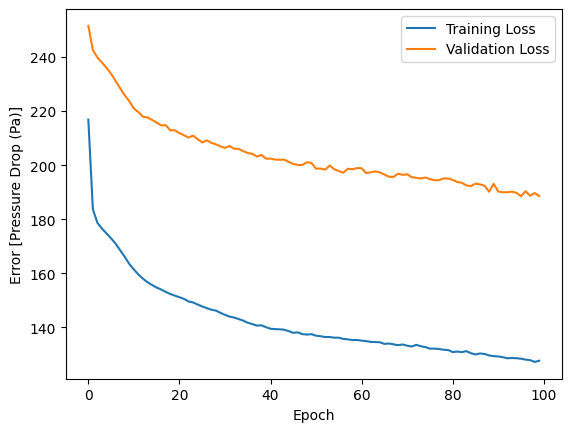

Model Error: 22.437910079956055 MAE
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


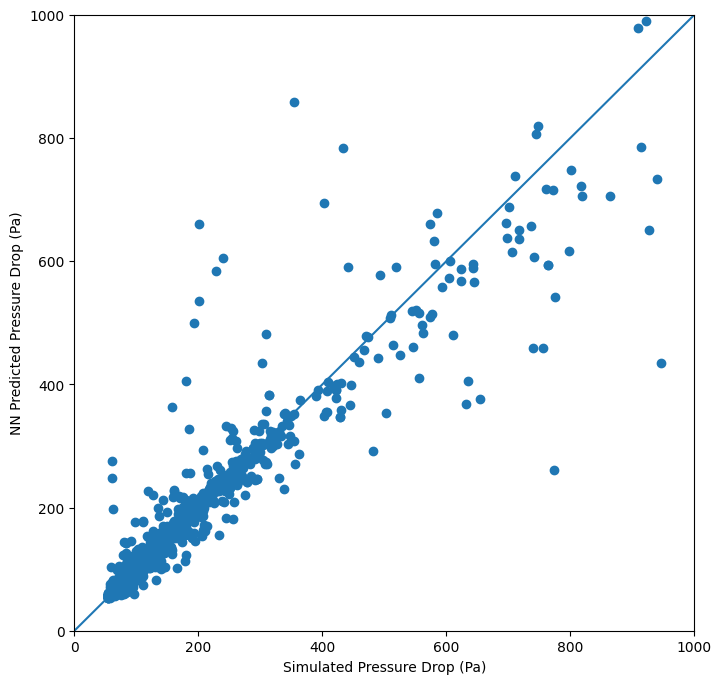

<Sequential name=sequential, built=True>

In [11]:
train_model()

In [13]:
predictions = predict(study)
predictions.style

Model predictions for Study: Single Opt - Min 1 Const
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/s

,Design Name,STAR-CCM+ Pressure Drop (Pa),NN Pressure Drop (Pa),Error (Pa),% Error
0,"""Design 1""",119.471727,124.663643,-5.191916,-4.345728
1,"""Design 2""",1831.884859,1945.056519,-113.171660,-6.177881
2,"""Design 3""",72.405679,76.072250,-3.666571,-5.063927
3,"""Design 4""",82.108275,85.575508,-3.467233,-4.222758
4,"""Design 5""",69.687904,68.514076,1.173828,1.684407
5,"""Design 6""",237.112324,241.753220,-4.640895,-1.957256
6,"""Design 7""",242.244478,249.761459,-7.516982,-3.103056
7,"""Design 8""",63.156142,63.903732,-0.747591,-1.183718
8,"""Design 9""",72.045621,75.818726,-3.773104,-5.237104
9,"""Design 10""",82.137873,84.801559,-2.663687,-3.242946
